# Sentiment Analysis on IMDB Reviews using LSTM and BILSTM and Keras
Realised by :EL-ALAOUI Ali & Adnane HAKEM

### Importing Required Libraries

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import LSTM,Activation, Dropout, Dense,Bidirectional
from keras.callbacks import ModelCheckpoint
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.regularizers import l1,l2
from  matplotlib import pyplot as plt

### Importing and Analyzing the Dataset

In [ ]:
movie_reviews = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/IMDB Dataset.csv")

#movie_reviews.isnull().values.any()

movie_reviews.shape

(50000, 2)

In [ ]:

movie_reviews.head()


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
movie_reviews["review"][10]

'Phil the Alien is one of those quirky films where the humour is based around the oddness of everything rather than actual punchlines.<br /><br />At first it was very odd and pretty funny but as the movie progressed I didn\'t find the jokes or oddness funny anymore.<br /><br />Its a low budget film (thats never a problem in itself), there were some pretty interesting characters, but eventually I just lost interest.<br /><br />I imagine this film would appeal to a stoner who is currently partaking.<br /><br />For something similar but better try "Brother from another planet"'

You can see that our text contains punctuations, brackets, and a few HTML tags as well. We will preprocess this text in the next section.

In [ ]:
movie_reviews["sentiment"][10]

'negative'

let's see the distribution of positive and negative sentiments in our dataset.

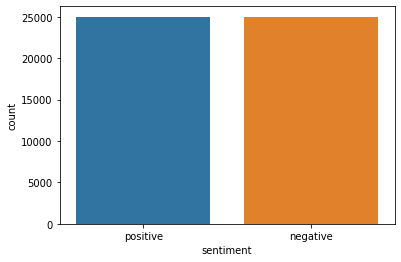

In [ ]:
import seaborn as sns

sns.countplot(x='sentiment', data=movie_reviews)

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords  
english_stops= set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Data Preprocessing
We saw that our dataset contained punctuations and HTML tags. In this section we will define a function that takes a text string as a parameter and then performs preprocessing on the string to remove special characters and HTML tags from the string. Finally, the string is returned to the calling function. Look at the following script:

we will preprocess our reviews and will store them in a new list as shown below:

In [ ]:
def preprocess_text():
    x_data = movie_reviews['review']       # Reviews/Input
    y_data = movie_reviews['sentiment']    # Sentiment/Output

    # PRE-PROCESS REVIEW
    x_data = x_data.replace({'<.*?>': ''}, regex = True)          # remove html tag
    x_data = x_data.replace({'[^A-Za-z]': ' '}, regex = True)     # remove non alphabet
    x_data = x_data.apply(lambda review: [w for w in review.split() if w not in english_stops])  # remove stop words
    x_data = x_data.apply(lambda review: [w.lower() for w in review])   # lower case
    
    # ENCODE SENTIMENT -> 0 & 1
    y_data = y_data.replace('positive', 1)
    y_data = y_data.replace('negative', 0)

    return x_data, y_data

In [ ]:
x_data, y_data=preprocess_text()

we will preprocess our reviews and will store them in a new list as shown below:

In [ ]:
print("Before preprossing")
movie_reviews["review"][10]

Before preprossing


'Phil the Alien is one of those quirky films where the humour is based around the oddness of everything rather than actual punchlines.<br /><br />At first it was very odd and pretty funny but as the movie progressed I didn\'t find the jokes or oddness funny anymore.<br /><br />Its a low budget film (thats never a problem in itself), there were some pretty interesting characters, but eventually I just lost interest.<br /><br />I imagine this film would appeal to a stoner who is currently partaking.<br /><br />For something similar but better try "Brother from another planet"'

In [ ]:
print("After preprossing")
' '.join(x_data[10])

After preprossing


'phil alien one quirky films humour based around oddness everything rather actual punchlines at first odd pretty funny movie progressed i find jokes oddness funny anymore its low budget film thats never problem pretty interesting characters eventually i lost interest i imagine film would appeal stoner currently partaking for something similar better try brother another planet'

Finally, we need to divide our dataset into train and test sets. The train set will be used to train our deep learning models while the test set will be used to evaluate how well our model performs.

We can use train_test_split method from the sklearn.model.selection module, as shown below:

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x_data,y_data, test_size=0.20, random_state=42)
print('Train Set')
print(x_train, '\n')
print(x_test, '\n')
print('Test Set')
print(y_train, '\n')
print(y_test)

Train Set
39087    [that, i, kept, asking, many, fights, screamin...
30893    [i, watch, entire, movie, i, could, watch, ent...
45278    [a, touching, love, story, reminiscent, in, mo...
16398    [this, latter, day, fulci, schlocker, totally,...
13653    [first, i, firmly, believe, norwegian, movies,...
                               ...                        
11284    [shadow, magic, recaptures, joy, amazement, fi...
44732    [i, found, movie, quite, enjoyable, fairly, en...
38158    [avoid, one, it, terrible, movie, so, exciting...
860      [this, production, quite, surprise, i, absolut...
15795    [this, decent, movie, although, little, bit, s...
Name: review, Length: 40000, dtype: object 

33553    [i, really, liked, summerslam, due, look, aren...
9427     [not, many, television, shows, appeal, quite, ...
199      [the, film, quickly, gets, major, chase, scene...
12447    [jane, austen, would, definitely, approve, one...
39489    [expectations, somewhat, high, i, went, see, m...
 

### Preparing the Embedding Layer

As a first step, we will use the Tokenizer class from the keras.preprocessing.text module to create a word-to-index dictionary. In the word-to-index dictionary, each word in the corpus is used as a key, while a corresponding unique index is used as the value for the key. 

In [ ]:
tokenizer = Tokenizer(num_words=5000,lower=False)
tokenizer.fit_on_texts(x_train)

X_train = tokenizer.texts_to_sequences(x_train)
X_test = tokenizer.texts_to_sequences(x_test)
print(X_train[20])

[228, 1936, 1564, 102, 541, 2792, 231, 4, 129, 243, 42, 109, 110, 33, 367, 1936, 2, 259, 380, 476, 204, 231, 4, 163, 450, 281, 1286, 8, 96, 147, 352, 465, 100, 2, 1450, 4638, 726, 16, 613, 848, 60, 439, 1470, 394, 1, 26, 281, 823, 584, 11, 1834, 569, 67, 1395, 89, 3511, 507, 96, 147, 352, 465, 82, 228, 1936, 2, 86, 771, 274, 122, 61, 205, 127, 1, 12, 445, 280, 109, 367, 2, 271, 1731, 741, 613]


If you view the X_train variable in variable explorer, you will see that it contains 40,000 lists where each list contains integers. Each list actually corresponds to each sentence in the training set. You will also notice that the size of each list is different. This is because sentences have different lengths

In [ ]:
vocab_size = len(tokenizer.word_index) + 1

max_review_length=100

X_train = pad_sequences(X_train, padding='post', maxlen=max_review_length)
X_test = pad_sequences(X_test, padding='post', maxlen=max_review_length)
print(X_train[10])

[   1  408  134  519  135  135    1  611  821 3392  131   38  551 1334
  395 1222  574  574 3379  826   38  551  164 1367  422 1278   13 1786
  905  236  135  681   42   70  228  943  959  829    7  139  338   31
  138   58    1  451  212   38   35  174    5    1  183  135    4 1639
 4027 1051    4  287  128  390  113  179 1154 4373  258 1773    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


# Model building


In [ ]:
'''Remember that our input is a sequence of words (technically, integer word IDs) of maximum length = max_review_length, and our output is a binary sentiment 
label (0 or 1).'''
#create the model
top_words = 5000 #vocabulary_size = 5000
embedding_vecor_length =32
max_review_length = 100
model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length, input_length=max_review_length))
model.add(Dropout(0.6))
model.add(LSTM(64,kernel_regularizer=l2(0.008)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
'''We first need to compile our model by specifying the loss function and optimizer we want to use while training, as well as any evaluation metrics 
we’d like to measure. Specify the appropriate parameters, including at least one metric ‘accuracy’.'''


model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

checkpoint2 =ModelCheckpoint("best_model2.hdf5", monitor='val_accuracy', verbose=1,save_best_only=True, mode='auto', period=1,save_weights_only=False)


history=model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32,callbacks=[checkpoint2])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 32)           160000    
_________________________________________________________________
dropout_2 (Dropout)          (None, 100, 32)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                24832     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 184,897
Trainable params: 184,897
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
1250/1250 [==============================] - 20s 9ms/step - loss: 0.7304 - accuracy: 0.5500 - val_

In [ ]:
#Calculate Accuracy
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 88.18%


In [ ]:
def show_train_history(train_history,train,validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

In [ ]:
# checkpoint
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.load_weights('/content/best_model2.hdf5')

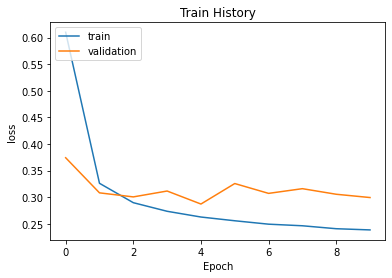

In [ ]:
#train loss vs validation loss
show_train_history(history,'loss','val_loss')

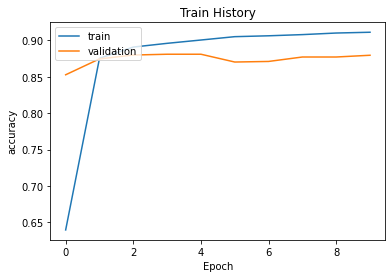

In [ ]:
#Accuracy History
show_train_history(history,'accuracy','val_accuracy')

### testing our model
Nothing was typical about this Everything 
was beautifully done in this movie the story the flow 
the scenario everything I highly recommend it for mystery 
lovers for anyone who wants to watch a good movie

In [ ]:
#i loved that movie,i liked that movie,i hated that movie
review=str(input('Movie Review: '))
# Pre-process input
regex = re.compile(r'[^a-zA-Z\s]')
review = regex.sub('', review)

words = review.split(' ')
filtered = [w for w in words if w not in english_stops]
filtered = ' '.join(filtered)
filtered = [filtered.lower()]
tokenize_words = tokenizer.texts_to_sequences(filtered)
tokenize_words = pad_sequences(tokenize_words, maxlen=100, padding='post', truncating='post')
#print(tokenize_words)
print(model.predict(tokenize_words))
result=model.predict(tokenize_words)
print(review)
if result >= 0.7:
    print('positive  😊')
else:
    print('negative  🥺 ')

# BILSTM

In [ ]:
vocab_size=5000
bimodel = Sequential()
bimodel.add(Embedding(vocab_size,embedding_vecor_length, input_length=max_review_length))
bimodel.add(Dropout(0.6))
bimodel.add(Bidirectional(LSTM(128,kernel_regularizer=l2(0.008))))
bimodel.add(Dropout(0.5))
bimodel.add(Dense(1,activation='sigmoid'))
bimodel.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
bimodel.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 100, 32)           160000    
_________________________________________________________________
dropout_20 (Dropout)         (None, 100, 32)           0         
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 256)               164864    
_________________________________________________________________
dropout_21 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 257       
Total params: 325,121
Trainable params: 325,121
Non-trainable params: 0
_________________________________________________________________


In [ ]:

bihistory=bimodel.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)


Epoch 1/10
1250/1250 [==============================] - 21s 15ms/step - loss: 0.7068 - accuracy: 0.6095 - val_loss: 0.3183 - val_accuracy: 0.8745
Epoch 2/10
1250/1250 [==============================] - 18s 15ms/step - loss: 0.3072 - accuracy: 0.8835 - val_loss: 0.3048 - val_accuracy: 0.8807
Epoch 3/10
1250/1250 [==============================] - 19s 15ms/step - loss: 0.2799 - accuracy: 0.8950 - val_loss: 0.3222 - val_accuracy: 0.8798
Epoch 4/10
1250/1250 [==============================] - 19s 15ms/step - loss: 0.2637 - accuracy: 0.9009 - val_loss: 0.3026 - val_accuracy: 0.8748
Epoch 5/10
1250/1250 [==============================] - 19s 15ms/step - loss: 0.2566 - accuracy: 0.9048 - val_loss: 0.3041 - val_accuracy: 0.8760
Epoch 6/10
1250/1250 [==============================] - 19s 15ms/step - loss: 0.2522 - accuracy: 0.9071 - val_loss: 0.3068 - val_accuracy: 0.8779
Epoch 7/10
1250/1250 [==============================] - 19s 15ms/step - loss: 0.2469 - accuracy: 0.9094 - val_loss: 0.3224 -

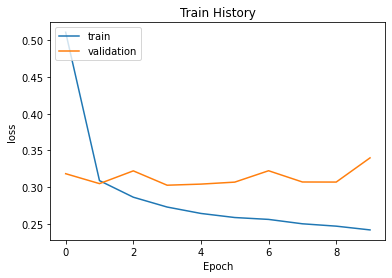

In [ ]:
show_train_history(bihistory,'loss','val_loss')

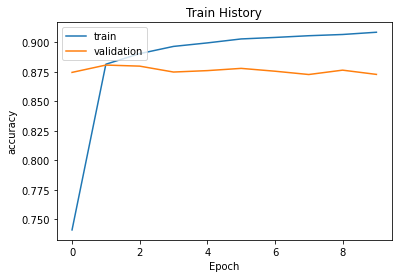

In [ ]:
show_train_history(bihistory,'accuracy','val_accuracy')

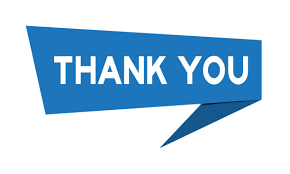